# ccdproc Example Reduction

This notebook will walk you through an example reduction of optical CCD data using ``ccdproc``.

The data is available at this link (about 500MB): http://physics.mnstate.edu/craig/2013-07-03-r-only.zip

## 1. Required software:

Please make sure you have this software installed before you begin (in addition to the usual scipy, numpy):

+ [astropy](http://astropy.org) v 0.4 or higher (install with: ``pip install astropy`` in a terminal/command window)
+ [ccdproc](http://ccdproc.readthedocs.org) v 0.1.1 or higher (install with: ``pip install ccdproc`` in a terminal/command window)
+ [msumastro](http://msumastro.readthedocs.org) v 0.5 or higher (install with : ``pip install msumastro`` in a terminal/command window)


In [14]:
# under virtual env!!!
#!pip install msumastro
#!conda install --channel https://conda.anaconda.org/astropy ccdproc

## 2. Imports you will always need

In [17]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

from astropy.modeling import models
from astropy import units as u
from astropy import nddata
from astropy.io import fits

import ccdproc

### Optional import 2 (it is used in this notebook): msumastro

Though most of the ``msumastro`` package is about massaging the headers of images taken from a particular small observatory, there is one useful bit for working with a set of FITS images in a directly.

**There is no easy way to remove this import**, but it is a pure python package, so ``pip install msumastro`` should work on any platform.

In [18]:
from msumastro import ImageFileCollection, TableTree

In [19]:
# I know you can't do correlated errors....
nddata.conf.warn_unsupported_correlated = False

# 3. Set some properties of the instrument that took these images...

In [20]:
gain = 4.40 * u.electron / u.adu
#readnoise = 29 * u.electron  # wish it wasn't, but it really seems to be...

# 4. Define a few convenience functions

All of these aare really optional, but some are pretty convenient. They are provided in part to illustrate how one can combine the basic ``ccdproc`` commands into something more like a pipeline.

## a. Subtract overscan and trim images in a list

In [21]:
def oscan_and_trim(image_list):
    """
    Remove overscan and trim a list of images. The original list is replaced by a list of images
    with the changes applied.
    """
    for idx, img in enumerate(image_list):
        oscan = ccdproc.subtract_overscan(img, img[:, 3075:3079], add_keyword={'oscan_sub': True, 'calstat': 'O'}, model=models.Polynomial1D(1))
        image_list[idx] = ccdproc.trim_image(oscan[:, :3073], add_keyword={'trimmed': True, 'calstat': 'OT'})

### A bottleneck-based replacement for a stack (i.e. list) of masked arrays

By "stack" I mean a group of images, e.g. darks of the same exposure, for which the appropriate baseline image for identifying bad pixels is a median image (rather than a median or mean of the whole stack)

In [63]:
def avg_over_images(masked_arr, axis=0):
    """
    Calculate average pixel value along specified axis
    """
    return ma.mean(masked_arr, axis=axis)

def med_over_images(masked_arr, axis=0):
    """
    Calculate median pixel value along specified axis
    
    Uses bottleneck.nanmedian for speed
    """
    
    dat = masked_arr.data.copy()
    dat[masked_arr.mask] = np.NaN
    return np.nanmedian(dat, axis=axis)

## c. A little function for displaying image statistics....

...which is useful for determining scale when displaying an image.

In [23]:
imstats = lambda dat: (dat.min(), dat.max(), dat.mean(), dat.std())

# 5. Read data

``ImageFileCollection`` is part of the `msumastro` package -- it constructs a table of the FITS keyword values for the files in a directory and provides methods for iterating over the files. The docs for the package are a bit of a mess, but are at http://msum-astro.readthedocs.org (or skip right to the useful bit, the [API for ImageFileCollection](http://msum-astro.readthedocs.org/en/latest/api/msumastro.image_collection.ImageFileCollection.html#msumastro.image_collection.ImageFileCollection)).


The code below reads through the headers of all of the FITS files in the ``data_dir``, creates an ``astropy`` ``Table`` of the keywords, and provides a few methods for iterating over the files.

##### Modify ``data_dir`` to point at your copy of the data!

In [28]:
data_dir = 'temp'

images = ImageFileCollection(data_dir, keywords='*')

# 6. Make a master bias

This is straightforward because all we do is:

+ subtract overscan
+ trim
+ combine using average

### a. First, load the data as a list of ``CCDData`` objects.

If you don't need to modify the metadata you could use ``ccdproc.CCDData.from_hdu(hdu)`` to create the ``CCDData`` object.

In [30]:
import os
def list_to_file(list_, filename, sep='\n'):
    with open(filename, 'w') as fid:
        for item in list_:
            fid.write('%s%s' % (str(item), sep))

def to_list(something):
    return something if isinstance(something, list) else [something]

def filter_fits_by_header(fits_filenames, fits_path='.', match_any=False, ignore_case=True,
                          ignore_edge_spaces=True, hdu_num=0, **kwargs):
    iffs = [os.path.join(fits_path, os.path.basename(iff)) for iff in to_list(fits_filenames)]
    res = []
    for iff in iffs:
        fits_file = fits.open(iff)
        fits_file_header = fits.getheader(iff, hdu_num)
        keywords_match = 0
        for keyword, value in kwargs.iteritems():
            if keyword in fits_file_header:
                header_val = str(fits_file_header[keyword]).strip() if ignore_edge_spaces \
                else str(fits_file_header[keyword])
                header_val = header_val.lower() if ignore_case else header_val
                kwargs_val = str(value).strip() if ignore_edge_spaces else str(value)
                kwargs_val = kwargs_val.lower() if ignore_case else kwargs_val
                if header_val == kwargs_val:
                    keywords_match += 1
                    if match_any:
                        break
        if (keywords_match and match_any) or (keywords_match == len(kwargs)):
            res.append(iff)
    return res

def change_header(fits_filename, fits_path='.', new_path=None, clobber=True, **kwargs):
    iff = os.path.join(fits_path, os.path.basename(fits_filename))
    data, header = fits.getdata(iff, header=True)
    for keyword, value in kwargs.iteritems():
        header[keyword] = value
    if new_path is None:
        new_path = fits_path
    iff = os.path.join(new_path, os.path.basename(iff))
    fits.writeto(iff, data, header, clobber=clobber)
    return iff

def to_header_str_format(str_value, length=8):
    return str_value.strip().ljust(length)

def apply_to_fits(fits_filenames, fits_path='.', func=None):
    iffs = [os.path.join(fits_path, os.path.basename(iff)) for iff in to_list(fits_filenames)]
    if not func:
        return iffs
    res = []
    for iff in iffs:
        res.append(func(iff))
    return res

In [36]:
#bias_list = filter_fits_by_header(images.files, 'temp', EXPTYPE='Bias')
bias_list = []
for hdu, fname in images.hdus(exptype='bias', return_fname=True):
    meta = hdu.header
    meta['filename'] = fname
    bias_list.append(ccdproc.CCDData(data=hdu.data, meta=meta, unit="adu"))

### b. Subtract overscan and trim using convenience function

In [38]:
#oscan_and_trim(bias_list)

### c. Combine biases using average

In [54]:
biases = ccdproc.Combiner(bias_list, dtype=np.float)
master_bias = biases.median_combine()
master_bias.write('test_masterbias.fits', clobber=True)

### d. Make a pretty picture...

Because why wouldn't you?

In [55]:
bias_min, bias_max, bias_mean, bias_std = imstats(np.asarray(master_bias))

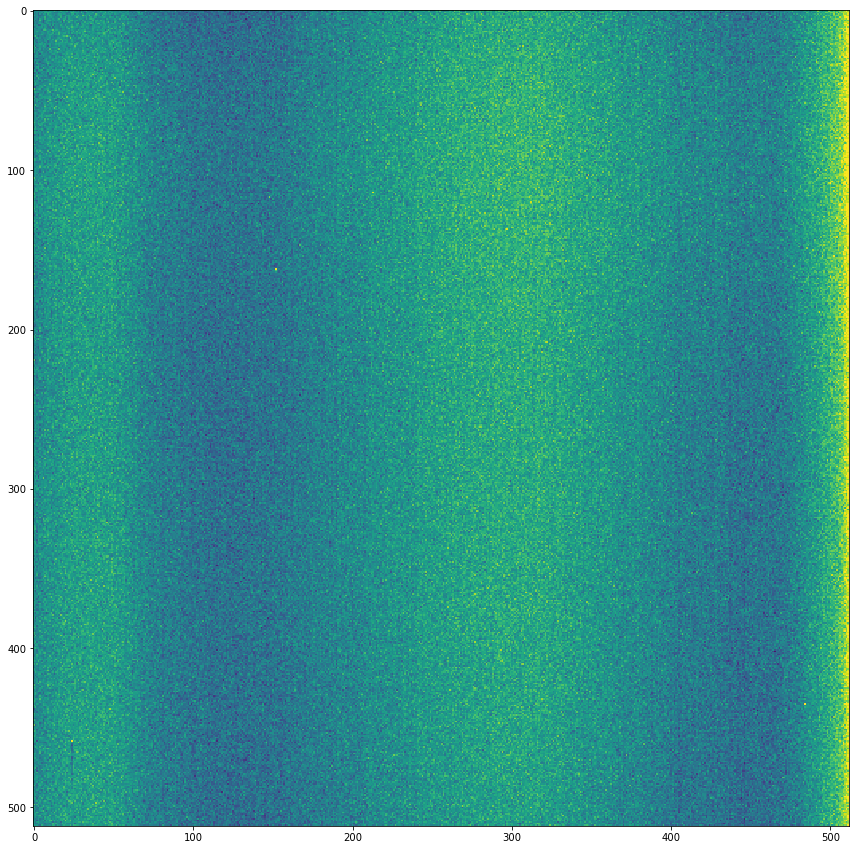

In [57]:
plt.figure(figsize=(15, 15))
plt.imshow(master_bias, vmax=bias_mean + 4*bias_std, vmin=bias_mean - 4*bias_std)

# 7. Make some master darks

More complicated than the bias frames because we will:

+ subtract overscan
+ trim
+ sigma clip the image stack to remove outliers
+ combine using median

This will **be done twice**, once for each for darks with 15 sec and 30 sec exposures.

## a. Define convenince function (optional, justification below)

I'll make two, one a 30 second exposure for calibrating science frames, the other a 15 second exposure for calibrating a flat field.

Since I'm going to be making two, and I have no desire to write the code twice, I'll write a short function to do the job.

These darks are **not** bias-subtracted since their exposures match that of the images they will be used to calibrate. Because of this, they cannot be scaled to other exposure times.

In [65]:
def overscan_trim_and_sigma_clip_median(image_list, clip_baseline_func=med_over_images):
    """
    Combine a list of images using median
    
    This function does several steps:
    
    1. Subtract overscan
    2. Trim image
    3. sigma clip image using a median of the unclipped stack as the baseline
    4. combine the images on the list using median
    
    ** It modifies the images in the input list. **
    """
    #oscan_and_trim(image_list)
    combo = ccdproc.Combiner(image_list)
    combo.sigma_clipping(func=clip_baseline_func)
    return combo

## b. Make CCDData objects for darks and reduce

The implementation below is a little complicated because the reduction is written as a loop over two exposures. The *body* of the loop is where the reduction happends.

In [75]:
exposures = [2, 60]
master_darks = {}
combiners = {}
for exposure in exposures:
    # make list of darks with this exposure time
    a_list = []
    for dark, fname in images.hdus(exptype='dark', exptime=exposure, return_fname=True):
        meta = dark.header
        meta['filename'] = fname
        a_list.append(ccdproc.CCDData(data=dark.data, meta=meta, unit="adu"))

    # get the exposure time as it appears in the fits file for use as a dictionary key
    exposure_time_in_fits_file = a_list[0].header['exptime']
    
    # make a combiner for sigma clipping and median combine
    a_combiner = overscan_trim_and_sigma_clip_median(a_list)
    print "here"
    combiners[exposure_time_in_fits_file] = a_combiner
    master_darks[exposure_time_in_fits_file] = a_combiner.median_combine(median_func=np.median)

    # set the exposure time in the master -- right now combiner doesn't attempt to combine meta
    master_darks[exposure_time_in_fits_file].header['exptime'] = exposure_time_in_fits_file
    print "For exposure {} seconds there are {} bad pixels in the master.".format(exposure_time_in_fits_file,
                                                                                  master_darks[exposure_time_in_fits_file].mask.sum())

here
For exposure 2.0 seconds there are 0 bad pixels in the master.
here
For exposure 60.0 seconds there are 0 bad pixels in the master.


## b. Display a reduced image

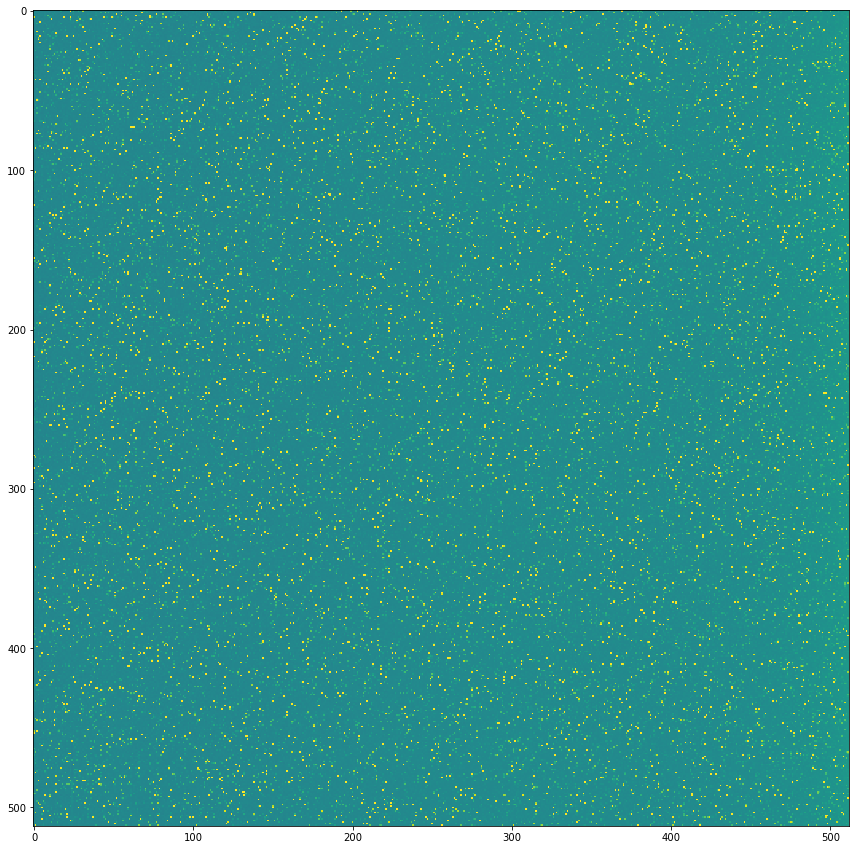

In [77]:
d_min, d_max, d_mean, d_std = imstats(np.asarray(master_darks[60.0]))
plt.figure(figsize=(15, 15))
plt.imshow(master_darks[60.0], vmax=d_mean + 4*d_std, vmin=d_mean - 4*d_std)

# 8. Make some flats now, R band only

This adds two more complications compared to the darks: subtracting darks and normalizing before combining.

The full set of steps will be:

+ Subtract overscan
+ Trim
+ Subtract dark (which includes bias, so no scaling)
+ Sigmal clip to remove outliers
+ Combine using mean, normalizing mean of each image to the same value
+ Use the gain to scale the flat from adu to electrons

### a. Read the files

In [80]:
flats_r = []
for flat, fname in images.hdus(exptype='light', filter='R', return_fname=True):
    meta = flat.header
    meta['filename'] = fname
    flats_r.append(ccdproc.CCDData(data=flat.data, meta=meta, unit="adu"))

### b. Calibrate the flats by subtracting dark

In [81]:
for flat in flats_r:
    flat_exposure = flat.header['exptime']
    master_dark = master_darks[flat_exposure]
    flat = ccdproc.subtract_dark(flat, master_dark, exposure_time='exptime', exposure_unit=u.second,
                              add_keyword={'calib': 'subtracted dark'})

### c. sigma clip

In [82]:
flat_combiner = ccdproc.Combiner(flats_r)

In [83]:
flat_combiner.sigma_clipping(func=med_over_images)

### d. define function for normalizing

``ccdproc`` tries to be flexible about how you can scale data during combination. That flexibility means you have to define a function to be used for scaling each image.

In [88]:
# this function will divide each array by its average before combining
# so that each array has an average of 1 after scaling (but before combining)
scaling_func = lambda arr: 1/np.ma.average(arr)
flat_combiner.scaling = scaling_func

In [89]:
master_flat_r = flat_combiner.median_combine(median_func=np.median)
master_flat_r.header = flats_r[0].meta  # kludge -- combiner does not try to combine metadata
master_flat_r.write('masterflat_test.fits', clobber=True)

### e. R-band flat, calibrated

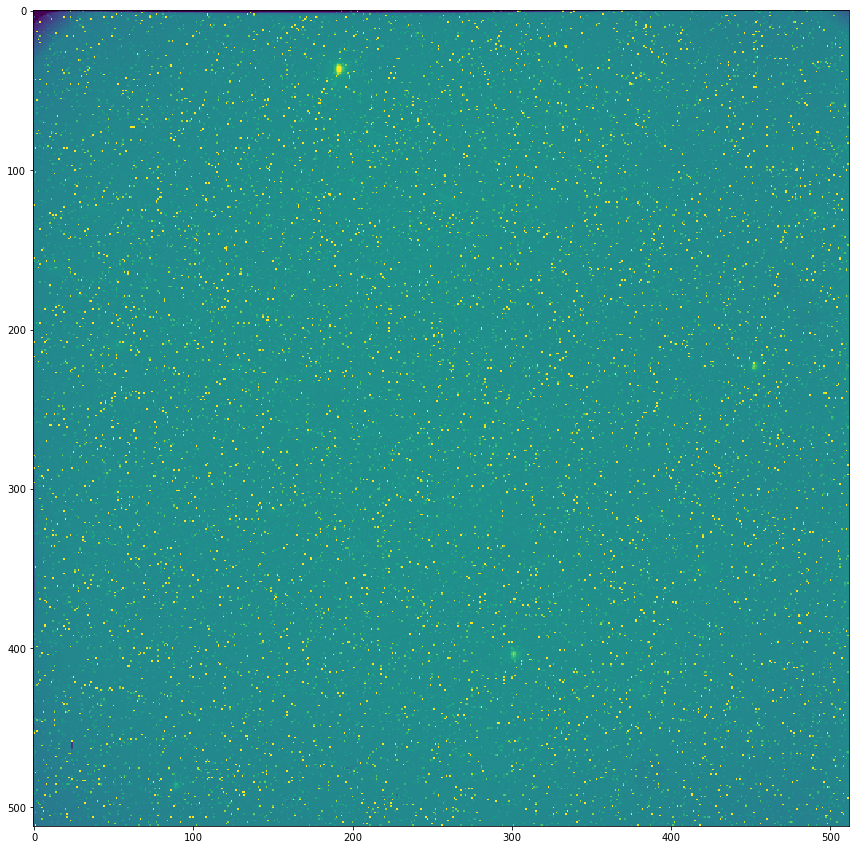

In [106]:
f_min, f_max, f_mean, f_std = imstats(np.asarray(master_flat_r_electron))
plt.figure(figsize=(15, 15))
plt.imshow(master_flat_r_electron, vmin=f_mean-5*f_std, vmax=f_mean+5*f_std)

### f. Gain-correct the flat

In [105]:
master_flat_r_electron = ccdproc.gain_correct(master_flat_r, gain=gain)

# 9. Calibrate some images of stars

These are images of the Landolt field SA112-SF1, roughly 20' x 30'

We'll do these steps:

+ Subtract overscan
+ Trim
+ ~~Remove cosmic rays~~ (coming soon!)
+ Subtract dark (we have darks who exposure match this science image, so no scaling)
+ Divide by flat

### a. Read the images

In [103]:
star_list = []
for star, fname in images.hdus(exptype='light', filter='R', return_fname=True):
    meta = star.header
    meta['filename'] = fname
    star_list.append(ccdproc.CCDData(data=star.data, meta=meta, unit="adu"))
res_star_list = []
for l in star_list:
    if l.meta['filename'][:4] != 'flat':
        res_star_list.append(l)
print len(star_list)
print len(res_star_list)
star_list = res_star_list

70
60


### b. Subtract overscan and trim...

In [104]:
#oscan_and_trim(star_list)

## c. ~~Remove cosmic rays~~ -- coming soon!

This was effectively handled by sigma clipping in the case of darks and flats. Sigma clipping in this case would remove the bright things (like stars), so we'll use one of the cosmic ray cleaning functions instead.

To check where cosmic rays were found, save the masks before running the cosmic ray cleaner then compare to mask after.

In [30]:
original_masks = []
for star in star_list:
    try:
        original_masks.append(star.mask.copy())
    except AttributeError:
        original_masks.append(None)
print original_masks

[None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None]


### Note: cosmic ray cleaning is coming soon!

In [31]:
#star_list_cr_cleaned = []
#for star in star_list:
#    star_no_nan = star.copy()
#    star_no_nan.data[np.isnan(star.data)] = 1e21
    #cr_cleaned = ccdp.cosmicray_clean(star, 9, ccdp.cosmicray_median, crargs=(11,), background=ccdp.background_variance_box,
    #                                  bargs=(25,), rbox=11)
    #star_list_cr_cleaned.append(cr_cleaned)     

In [32]:
#for star in star_list:
#    try:
#        print "Found {} cosmic rays in {}".format(star.mask.sum(), star.meta['filename'])
#    except AttributeError:
#        print "Found 0 cosmic rays in {}".format(star.meta['filename'])

### Sample image with cosmic rays marked

In [33]:
#an_image = star_list_cr_cleaned[0]
#print imstats(an_image)

In [34]:
#imshow(an_image, vmin=9-3*27, vmax=9+10*27)
#ycr, xcr = where(an_image.mask)
#plot(xcr, ycr, 'o', fillstyle='none', markeredgecolor='red', markersize=5)

### d. Calibrate science images

##### Currently based on the non-cosmic ray cleaned images

In [107]:
star_calibrated = []
mask_info = lambda name, num: "Pixels masked after {}: {}".format(name, num) 
mask_num = lambda mask: 0 if mask is None else mask.sum()
for star in star_list:
    star_exp = star.meta['exptime']
    star_dark = ccdproc.subtract_dark(star, master_darks[star_exp], exposure_time='exptime', exposure_unit=u.second)    
    star_gain = ccdproc.gain_correct(star_dark, gain=gain)
    star_flat = ccdproc.flat_correct(star_gain, master_flat_r_electron)
    star_calibrated.append(star_flat)

In [110]:
for star in star_calibrated:
    star.write('temp/res_test/' + star.meta['filename'], clobber=True)

### e. Display sample calibrated image

In [36]:
star_0 = star_calibrated[0]
star_0 = ccdproc.create_variance(star_0, readnoise=readnoise)
ma_star_0 = np.ma.array(star_0.data, mask=star_0.mask)
mean_star_0 =  np.ma.mean(ma_star_0)
std_star_0 = np.ma.std(ma_star_0)

/Users/mcraig/Development/astronomy/ccdproc/ccdproc/core.py:102: RuntimeWarning: invalid value encountered in sqrt
  var = (gain_value * ccd_data.data + readnoise_value ** 2) ** 0.5


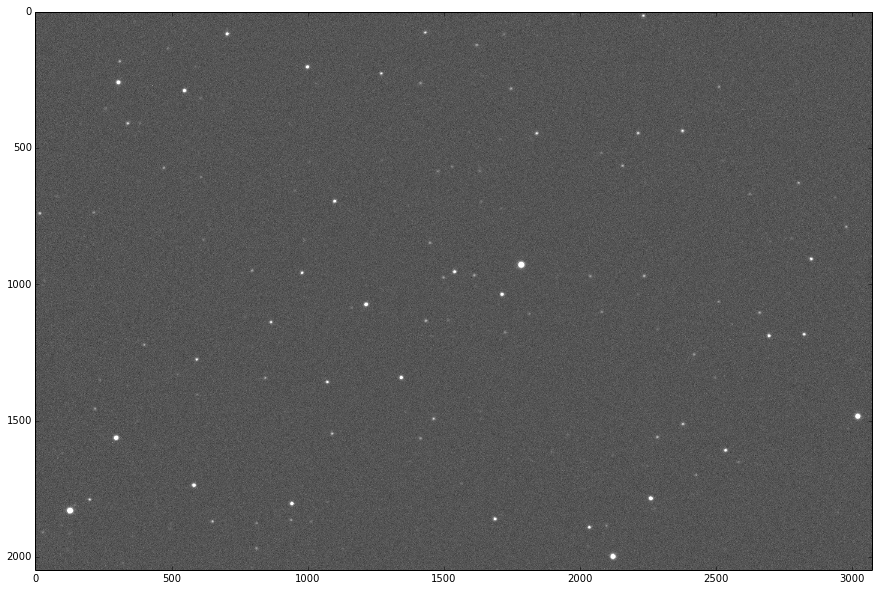

In [37]:
plt.figure(figsize=(15, 15))
plt.imshow(ma_star_0, vmin=mean_star_0 - 5*std_star_0, vmax=mean_star_0+10*std_star_0, cmap='gray')

#### Same image, uncalibrated

To try and match the image above, it is plotted about its own mean, with upper/lower limit set to those in amge above, downscaled by gain

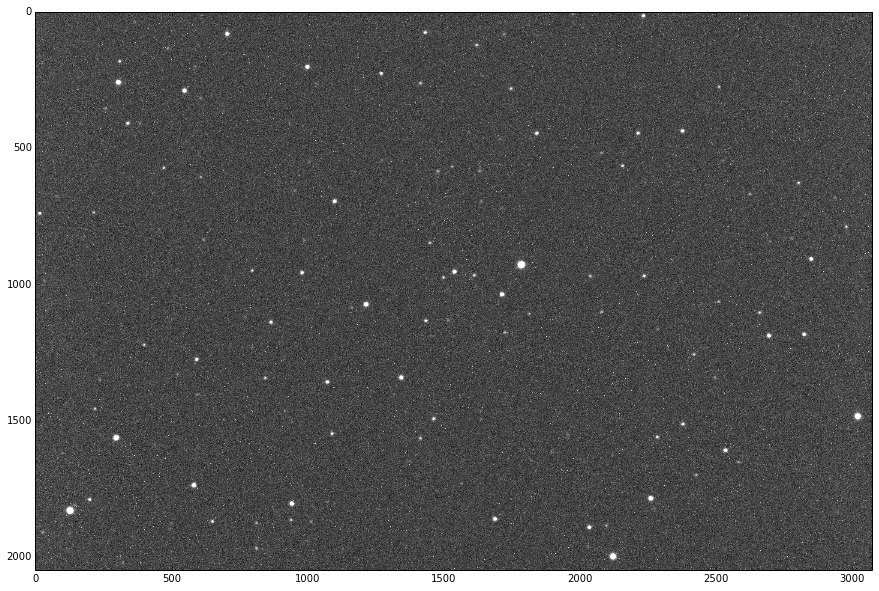

In [38]:
std_dev = mean_star_0/gain.value
star_0_uncal = star_list[0]
star_0_uncal = ccdproc.create_variance(star_0_uncal, gain=gain, readnoise=readnoise)
mean_0_uncal = star_0.data.mean()
plt.figure(figsize=(15, 15))
plt.imshow(star_list[0].data, vmin=mean_0_uncal-5*std_dev, vmax=mean_0_uncal+10*std_dev, cmap='gray')

## Epilogue: Create a multi-extension FITS file to hold this reduced image, uncertainty, mask

There is nothing approaching a standard as to how a dataset like a masked array should be stored. this is most definitely *NOT* intended as any sort of standard....

In [39]:
image_hdu_list = star_0.to_hdu()

In [40]:
image_hdu_list[0].header['bunit'] = u.photon.to_string()

In [41]:
uncertainty_header = fits.Header()
uncertainty_header['bunit'] = u.photon.to_string()
uncertainty_header['name'] = 'uncertainty'
uncertainty_hdu = fits.ImageHDU(data=star_0.uncertainty.array, header=uncertainty_header, name='uncertainty')
image_hdu_list.append(uncertainty_hdu)

In [42]:
mask_header = fits.Header()
mask_header.add_comment('TRUE indicates the data is INVALID')
# FITS isn't fond of boolean images -- convert it to 32 bit integers, nonzero indicates True
mask_array = np.zeros_like(star_0.mask, dtype=np.int32)
mask_array[star_0.mask] = 1
mask_hdu = fits.ImageHDU(data=mask_array, header=mask_header, name='mask')
image_hdu_list.append(mask_hdu)

In [43]:
import os
fname_base = os.path.basename(star_0.header['filename'])
image_hdu_list.writeto('reduced' + fname_base)